### Importing necessary libraries

In [705]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

### Loading the data

In [621]:
df = pd.read_csv('Customer_Churn_Dataset.csv')

Exploratory Data Analysis

In [622]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


In [623]:
df.shape

(7043, 23)

In [624]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Initially, let's convert the totalcharges column to a numeric column as it has currently been saved as an object

In [625]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [626]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.515689,0.419566
std,0.368612,24.559481,30.090047,2266.771362,1.275299,1.250117
min,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000,0.000000
75%,0.000000,55.000000,89.850000,3794.737500,0.000000,0.000000
max,1.000000,72.000000,118.750000,8684.800000,5.000000,9.000000


A lot of information can be inferred from this. It can be seen that the mean for the senior citizen variable is 0.16 showing that only around 16% of the total customers belong to that age range. It can also be seen that the monthly charges are between 18 and 118 suggesting not a huge range or discrepancy between minimum and maximum.

In [627]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
numAdminTickets      0
numTechTickets       0
Churn                0
dtype: int64

In [628]:
df = df.dropna()

In [629]:
df.duplicated().sum()

np.int64(0)

In [630]:
df = df.drop(columns =['customerID'],axis=1)

In [631]:
df['Churn'].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

Visualisations

In [632]:
num_cols = df.select_dtypes(include=['int64','float64'])
num_cols.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
0,0,1,29.85,29.85,0,0
1,0,34,56.95,1889.50,0,0
2,0,2,53.85,108.15,0,0
3,0,45,42.30,1840.75,0,3
4,0,2,70.70,151.65,0,0


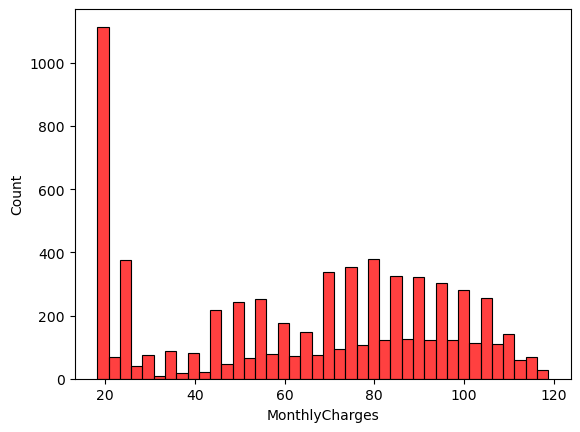

In [633]:
sns.histplot(num_cols['MonthlyCharges'],bins=40,color='red')
plt.show()

Most monthly charges tend to be around 20 while there are some small spikes where larger charges to the customers are present as well. 

#### Checking for outliers

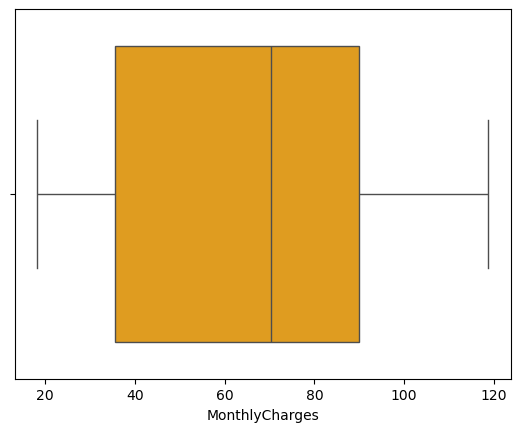

In [634]:
sns.boxplot(x=num_cols['MonthlyCharges'],color='orange')
plt.show()

As expected, there are no customers that are charged an amount enough to be deemed as an outlier. 

In [635]:
q1 = num_cols['MonthlyCharges'].quantile(0.25)
q3 = num_cols['MonthlyCharges'].quantile(0.75)
IQR = q3-q1
lower = q1 - 1.5 * IQR
upper = q3 - 1.5 * IQR
print(q1, q3, lower, upper)
print(df['MonthlyCharges'].min(), df['MonthlyCharges'].max())
outliers = num_cols[(num_cols['MonthlyCharges'] < lower) | (num_cols['MonthlyCharges'] > upper)]


35.5875 89.8625 -45.824999999999996 8.450000000000003
18.25 118.75


No outliers

Preprocessing 

In [636]:
cat_cols = df.select_dtypes(include = ['object'])
for col in cat_cols.columns:
    a = cat_cols[col].value_counts()
    print(col,': \n',a,'\n')

gender : 
 gender
Male      3549
Female    3483
Name: count, dtype: int64 

Partner : 
 Partner
No     3639
Yes    3393
Name: count, dtype: int64 

Dependents : 
 Dependents
No     4933
Yes    2099
Name: count, dtype: int64 

PhoneService : 
 PhoneService
Yes    6352
No      680
Name: count, dtype: int64 

MultipleLines : 
 MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64 

InternetService : 
 InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64 

OnlineSecurity : 
 OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64 

OnlineBackup : 
 OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: count, dtype: int64 

DeviceProtection : 
 DeviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: count, dtype: int

In [637]:
x = df.drop('Churn',axis=1)
y = df['Churn']

In [638]:
cat_cols_one_hot = x.select_dtypes(include='object').columns.tolist()
cat_cols_one_hot.remove('Contract')
cat_cols_label = ['Contract']

In [639]:
num_col = x.select_dtypes(include = ['float64', 'int64']).columns.tolist()

K-fold cross validation with k = 5 will be used in order to perform cross-validation on the model to ensure it's consistency.

In [640]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
score = []

In [641]:
for train_idx, val_idx in kf.split(x):

    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


Both label encoder and One Hot encoder will be used on the dataset to convert the categorical columns into numerical ones. This decision is based on a willful choice to only use the Label Encoder on the contract column as it has ordinal labels and One Hot encoder on the rest of the variables. 

In [642]:
label_encoder = LabelEncoder()
x_train_contract = label_encoder.fit_transform(x_train['Contract'])
x_val_contract = label_encoder.transform(x_val['Contract'])

In [643]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
x_train_cat = one_hot_encoder.fit_transform(x_train[cat_cols_one_hot])
x_val_cat = one_hot_encoder.transform(x_val[cat_cols_one_hot])

In [644]:
num_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SeniorCitizen    7032 non-null   int64  
 1   tenure           7032 non-null   int64  
 2   MonthlyCharges   7032 non-null   float64
 3   TotalCharges     7032 non-null   float64
 4   numAdminTickets  7032 non-null   int64  
 5   numTechTickets   7032 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 384.6 KB


In [645]:
scaler = StandardScaler()
x_train_num = scaler.fit_transform(x_train[num_col])
x_val_num = scaler.transform(x_val[num_col])

In [646]:
x_train_cat = x_train_cat.toarray()
x_val_cat = x_val_cat.toarray()

In [647]:
x_val_contract = x_val_contract.reshape(-1,1)
x_train_contract = x_train_contract.reshape(-1,1)

In [648]:
X_train = np.hstack([x_train_num,x_train_cat,x_train_contract])

X_val = np.hstack([x_val_num,x_val_contract,x_val_cat])

In [649]:
print(type(x_val_num), x_val_num.shape)
print(type(x_val_cat), x_val_cat.shape)
print(type(x_val_contract), x_val_contract.shape)


<class 'numpy.ndarray'> (1406, 6)
<class 'numpy.ndarray'> (1406, 38)
<class 'numpy.ndarray'> (1406, 1)


Modelling

In [650]:
from sklearn.metrics import recall_score, precision_score, accuracy_score,confusion_matrix,ConfusionMatrixDisplay

In [651]:
y_train.replace(('Yes','No'),(1,0),inplace=True)

C:\Users\cathy\AppData\Local\Temp\ipykernel_13344\299262512.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train.replace(('Yes','No'),(1,0),inplace=True)


In [652]:
y_val.replace(('Yes','No'),(1,0),inplace=True)

C:\Users\cathy\AppData\Local\Temp\ipykernel_13344\602283363.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val.replace(('Yes','No'),(1,0),inplace=True)


In [668]:
rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced',min_samples_split=3)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_val)
precision = precision_score(y_pred,y_val)
recall = recall_score(y_pred,y_val)
accuracy = accuracy_score(y_pred,y_val)
print('Precision :',precision,'Recall :',recall,'accuracy :',accuracy)
print(confusion_matrix(y_pred,y_val))

Precision : 0.002564102564102564 Recall : 0.2 accuracy : 0.7204836415362731
[[1012  389]
 [   4    1]]


Randomforest shows a low performance.

In [704]:
lg_model = LogisticRegression(solver='liblinear',penalty='l1',max_iter=200,random_state=42)
lg_model.fit(X_train,y_train)
y_pred = lg_model.predict(X_val)
precision = precision_score(y_pred,y_val)
recall = recall_score(y_pred,y_val)
accuracy = accuracy_score(y_pred,y_val)
print('Precision :',precision,'Recall :',recall,'accuracy :',accuracy)
print(confusion_matrix(y_pred,y_val))

Precision : 0.24871794871794872 Recall : 0.7698412698412699 accuracy : 0.7709815078236131
[[987 293]
 [ 29  97]]


In [669]:
cat_model = CatBoostClassifier()
cat_model.fit(X_train,y_train)
y_pred = cat_model.predict(X_val)
precision = precision_score(y_pred,y_val)
recall = recall_score(y_pred,y_val)
accuracy = accuracy_score(y_pred,y_val)
print('Precision :',precision,'Recall :',recall,'accuracy :',accuracy)
print(confusion_matrix(y_pred,y_val))

Learning rate set to 0.021541
0:	learn: 0.6690187	total: 186ms	remaining: 3m 5s
1:	learn: 0.6489542	total: 197ms	remaining: 1m 38s
2:	learn: 0.6321621	total: 201ms	remaining: 1m 6s
3:	learn: 0.6123837	total: 205ms	remaining: 51.1s
4:	learn: 0.5947262	total: 212ms	remaining: 42.3s
5:	learn: 0.5794091	total: 217ms	remaining: 35.9s
6:	learn: 0.5616181	total: 221ms	remaining: 31.4s
7:	learn: 0.5473366	total: 225ms	remaining: 27.9s
8:	learn: 0.5340836	total: 240ms	remaining: 26.5s
9:	learn: 0.5220871	total: 246ms	remaining: 24.4s
10:	learn: 0.5099461	total: 252ms	remaining: 22.6s
11:	learn: 0.5000270	total: 257ms	remaining: 21.2s
12:	learn: 0.4911713	total: 263ms	remaining: 19.9s
13:	learn: 0.4804010	total: 268ms	remaining: 18.9s
14:	learn: 0.4723959	total: 273ms	remaining: 17.9s
15:	learn: 0.4641276	total: 278ms	remaining: 17.1s
16:	learn: 0.4551604	total: 282ms	remaining: 16.3s
17:	learn: 0.4469395	total: 287ms	remaining: 15.7s
18:	learn: 0.4398608	total: 291ms	remaining: 15s
19:	learn: 0

In [703]:
xg_model = XGBClassifier()
xg_model.fit(X_train,y_train)
y_pred = xg_model.predict(X_val)
precision = precision_score(y_pred,y_val)
recall = recall_score(y_pred,y_val)
accuracy = accuracy_score(y_pred,y_val)
print('Precision :',precision,'Recall :',recall,'accuracy :',accuracy)
print(confusion_matrix(y_pred,y_val))

Precision : 0.35384615384615387 Recall : 0.700507614213198 accuracy : 0.7788051209103841
[[957 252]
 [ 59 138]]


In [707]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train,y_train)
y_pred = lgbm_model.predict(X_val)
precision = precision_score(y_pred,y_val)
recall = recall_score(y_pred,y_val)
accuracy = accuracy_score(y_pred,y_val)
print('Precision :',precision,'Recall :',recall,'accuracy :',accuracy)
print(confusion_matrix(y_pred,y_val))

Precision : 0.3282051282051282 Recall : 0.7804878048780488 accuracy : 0.7880512091038406
[[980 262]
 [ 36 128]]


c:\Users\cathy\anaconda3\envs\'musicenv'\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
